# DC2 Coadd Run1.1p GCR access

__Purpose__: This tutorial will illustrate the basics of accessing the merged coadd catalogs through the Generic Catalog Reader (GCR, https://github.com/yymao/generic-catalog-reader) as well as how to select useful samples of stars/galaxies from the DM outputs.


Note: This notebook is intended to be run through the JupyterHub NERSC interface available here: https://jupyter-dev.nersc.gov. To setup your NERSC environment, please follow the instructions available here: https://confluence.slac.stanford.edu/display/LSSTDESC/Using+Jupyter-dev+at+NERSC

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Accessing the coadd catalog with the GCR

The [GCRCatalogs](https://github.com/LSSTDESC/gcr-catalogs) package is a DESC project which aims at gathering in one convenient location various simulation/data catalogs made available to the collaboration.  
In this section, we illustrate how to use this tool to access the coadd catalogs from DC2 Run1.1p.

In [2]:
import GCRCatalogs
# Load the coadd catalog
catalog = GCRCatalogs.load_catalog('dc2_coadd_run1.1p')

A significant numbers of catalogs besides the DC2 coadd are already available, use `sorted(GCRCatalogs.get_available_catalogs(False))` to see a full list and visit the [DC2 Data Product](https://confluence.slac.stanford.edu/display/LSSTDESC/DC2+Data+Product+Overview) page to see all the DC2 related catalogs.

### DC2 Coadd catalog Schema


To see the quantities available in the catalog, you can use the following:

In [3]:
sorted(catalog.list_all_quantities())

['I_flag',
 'I_flag_g',
 'I_flag_i',
 'I_flag_r',
 'I_flag_u',
 'I_flag_y',
 'I_flag_z',
 'Ixx',
 'IxxPSF',
 'IxxPSF_g',
 'IxxPSF_i',
 'IxxPSF_r',
 'IxxPSF_u',
 'IxxPSF_y',
 'IxxPSF_z',
 'Ixx_g',
 'Ixx_i',
 'Ixx_r',
 'Ixx_u',
 'Ixx_y',
 'Ixx_z',
 'Ixy',
 'IxyPSF',
 'IxyPSF_g',
 'IxyPSF_i',
 'IxyPSF_r',
 'IxyPSF_u',
 'IxyPSF_y',
 'IxyPSF_z',
 'Ixy_g',
 'Ixy_i',
 'Ixy_r',
 'Ixy_u',
 'Ixy_y',
 'Ixy_z',
 'Iyy',
 'IyyPSF',
 'IyyPSF_g',
 'IyyPSF_i',
 'IyyPSF_r',
 'IyyPSF_u',
 'IyyPSF_y',
 'IyyPSF_z',
 'Iyy_g',
 'Iyy_i',
 'Iyy_r',
 'Iyy_u',
 'Iyy_y',
 'Iyy_z',
 'blendedness',
 'clean',
 'dec',
 'extendedness',
 'good',
 'mag_g',
 'mag_g_cModel',
 'mag_i',
 'mag_i_cModel',
 'mag_r',
 'mag_r_cModel',
 'mag_u',
 'mag_u_cModel',
 'mag_y',
 'mag_y_cModel',
 'mag_z',
 'mag_z_cModel',
 'magerr_g',
 'magerr_g_cModel',
 'magerr_i',
 'magerr_i_cModel',
 'magerr_r',
 'magerr_r_cModel',
 'magerr_u',
 'magerr_u_cModel',
 'magerr_y',
 'magerr_y_cModel',
 'magerr_z',
 'magerr_z_cModel',
 'objectId',
 'paren

The meaning of these fields is documented in the [SCHEMA.md](https://github.com/LSSTDESC/gcr-catalogs/blob/master/GCRCatalogs/SCHEMA.md#schema-for-dc2-coadd-catalogs) file of the `gcr-catalog` repository.  
As explained in that link, the values exposed here are not the native quantities produced by the Data Management stack, but instead this schema strives to follow the standard nomenclature of the LSST Data Products Definition Document [DPDD](http://ls.st/dpdd).

The DPDD is an effort made by the LSST project to standardize the format of the official Data Release Products (DRP). While the native outputs of the DM stack are succeptible to change, the DPDD will be more stable. An early adoption of these conventions by the DESC will save time and energy down the road.

This being said, not all use-cases and relevant quantities are covered by these conventions yet, so the GCR preserves access to the underlying native DM stack fieds, all 2046 of which can be listed using:  

In [39]:
sorted(catalog.list_all_native_quantities())

['base_Blendedness_abs_child_xx',
 'base_Blendedness_abs_child_xy',
 'base_Blendedness_abs_child_yy',
 'base_Blendedness_abs_flux',
 'base_Blendedness_abs_flux_child',
 'base_Blendedness_abs_flux_parent',
 'base_Blendedness_abs_parent_xx',
 'base_Blendedness_abs_parent_xy',
 'base_Blendedness_abs_parent_yy',
 'base_Blendedness_flag',
 'base_Blendedness_flag_noCentroid',
 'base_Blendedness_flag_noShape',
 'base_Blendedness_old',
 'base_Blendedness_raw_child_xx',
 'base_Blendedness_raw_child_xy',
 'base_Blendedness_raw_child_yy',
 'base_Blendedness_raw_flux',
 'base_Blendedness_raw_flux_child',
 'base_Blendedness_raw_flux_parent',
 'base_Blendedness_raw_parent_xx',
 'base_Blendedness_raw_parent_xy',
 'base_Blendedness_raw_parent_yy',
 'base_CircularApertureFlux_12_0_flag',
 'base_CircularApertureFlux_12_0_flag_apertureTruncated',
 'base_CircularApertureFlux_12_0_flux',
 'base_CircularApertureFlux_12_0_fluxSigma',
 'base_CircularApertureFlux_17_0_flag',
 'base_CircularApertureFlux_17_0_fl

==TODO== : Quickly go through the most important fields ?

### Accessing the data

While run1.1p is still of manageable size, full DC2 will be much larger, accessing the whole data can be challenging. In order to access the data efficiently, it is important to understand how it is physically stored and how to access it, one piece at the time. 


The coadds produced by the DM stack are structured in terms of large `tracts` and smaller `patches`, illustrated here for DC2:
<img src="assets/dc2_skymap.png">
Here the tracts have large blue numbers, and the patches are denoted with an `(x,y)` format. For DC2, each tract has 8x8 patches.

The GCR coadd catalog preserves this structure of the data so that any particular quantity can be accessed on a tract/patch bases. The tracts available in the catalog can be listed using the following command:

In [ ]:
# Query all available tracts and patches, only displays the first 5
catalog.available_tracts_and_patches[:5]

To access a particular part of the data, the GCR provides the following `native_filters` mechanism:


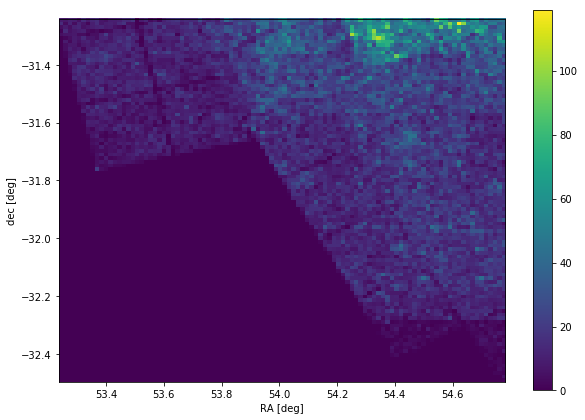

In [20]:
# Retrieve the ra,dec coordinates of all sources within tract number 4430
data = catalog.get_quantities(['ra', 'dec'], native_filters=[(lambda x: x==4430, 'tract')])

# Plot a 2d histogram of sources
figure(figsize=(10,7))
hist2d(data['ra'], data['dec'],100); gca().set_aspect('equal'); colorbar()
xlabel('RA [deg]');
ylabel('dec [deg]');

The data returned by the GCR is structured as a native Python dictionary:

In [6]:
data

{'ra': array([ 54.77311818,  54.77546161,  54.77206843, ...,  53.29860741,
         53.26474874,  53.26472113]),
 'dec': array([-32.49708021, -32.48377282, -32.48302019, ..., -31.23997516,
        -31.24027194, -31.23982085])}

But it can also easily be converted into a Pandas DataFrame, if you are so inclined ;-)

In [7]:
import pandas
pdata = pandas.DataFrame(data)
pdata

,dec,ra
0,-32.497080,54.773118
1,-32.483773,54.775462
2,-32.483020,54.772068
3,-32.481991,54.774730
4,-32.478149,54.778687
5,-32.477058,54.772377
6,-32.474778,54.775599
7,-32.467747,54.750606
8,-32.463775,54.762933
9,-32.462994,54.749376


As a simple test, you can show the advantage of loading one tract at a time compared to the entire catalog:

In [17]:
%time data = catalog.get_quantities(['ra', 'dec'], native_filters=[(lambda x: x==4431, 'tract')])

CPU times: user 402 ms, sys: 576 ms, total: 977 ms
Wall time: 3.14 s


In [19]:
%time data = catalog.get_quantities(['ra', 'dec'])

CPU times: user 13 s, sys: 24.9 s, total: 37.9 s
Wall time: 2min 54s


In order to make accessing chunks of data convenient to the user, the `catalog.get_quantities` also provides the option to return an iterator:

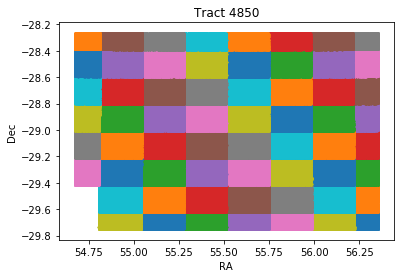

In [22]:
# Loop through all the patches of a given tract using an iterator
for d in catalog.get_quantities(['ra', 'dec'],
                                native_filters=[(lambda x: x==4850, 'tract')],
                                return_iterator=True):
    # Here we only handle a small amount of data at a time
    plt.scatter(d['ra'], d['dec'], s=2);
    
plt.xlabel('RA');
plt.ylabel('Dec');
plt.title('Tract 4850');

### Applying filters and cuts

In order to avoid returning unecessary data, the GCR has a functionality to filter out entries as it reads the files. Note that this is different from the `native_filters` discussed above, which avoids reading part of the data altogether.

Defining these filters requires the `GCRQuery` module of the GCR package and can then be applied during the call to `get_quantities`:

In [18]:
from GCR import GCRQuery

# Simple cut to remove unreliable detections
# More cuts can be added, as a logical AND, by appending GCRQuerys to this list
simple_cuts = [
    GCRQuery('clean'), # The source has no flagged pixels (interpolated, saturated, edge, clipped...) 
                       # and was not skipped by the deblender
]

# Loads the data after cut
data_cut = catalog.get_quantities(['ra', 'dec'], 
                              filters = simple_cuts, 
                              native_filters=[(lambda x: x==4849, 'tract')])

# Loads data without cuts
data_full = catalog.get_quantities(['ra', 'dec'], 
                              native_filters=[(lambda x: x==4849, 'tract')])

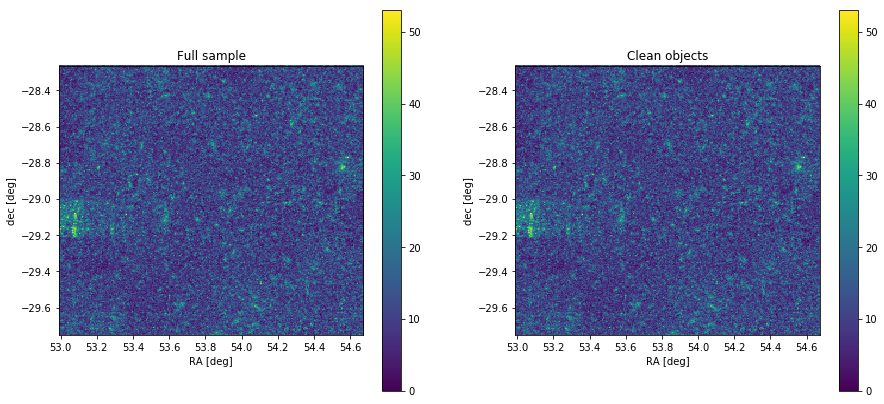

In [19]:
# Plot a 2d histogram of sources
figure(figsize=(15,7))
subplot(121)
hist2d(data_full['ra'], data_full['dec'],256); gca().set_aspect('equal'); 
xlabel('RA [deg]');
ylabel('dec [deg]');
title('Full sample')
colorbar()

subplot(122)
hist2d(data_cut['ra'], data_cut['dec'],256); gca().set_aspect('equal');
xlabel('RA [deg]');
ylabel('dec [deg]');
title('Clean objects');
colorbar()

==TODO==: Check this plot I'm a bit confused, I was expecting to see some cosmic rays and stars.... This example turned to be very underwhelming, maybe we should just go directly for star/galaxy separation

In [22]:
cat_hsc = GCRCatalogs.load_catalog('hsc-pdr1-xmm')

In [23]:
# Loads the data after cut
data_cut = cat_hsc.get_quantities(['ra', 'dec'], 
                              filters = simple_cuts)

# Loads data without cuts
data_full = cat_hsc.get_quantities(['ra', 'dec'])

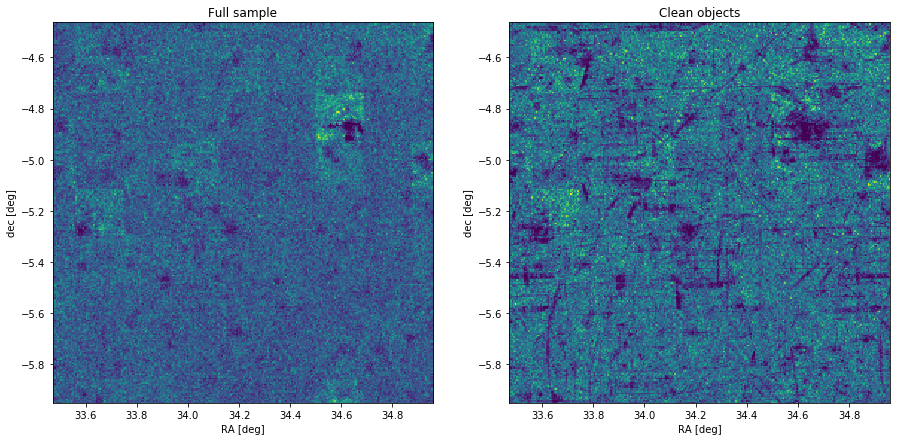

In [24]:
figure(figsize=(15,7))
subplot(121)
hist2d(data_full['ra'], data_full['dec'],256); gca().set_aspect('equal'); 
xlabel('RA [deg]');
ylabel('dec [deg]');
title('Full sample')

subplot(122)
hist2d(data_cut['ra'], data_cut['dec'],256); gca().set_aspect('equal');
xlabel('RA [deg]');
ylabel('dec [deg]');
title('Clean objects');

## Example of filtering: Star/galaxy separation

For now, we have `extendedness == base_ClassificationExtendedness_value` as a tool for star/galaxy classification. An object is considered extended if the the difference between the `PSF` magnitude and the `CModel` magnitude is beyond certain threshold (0.0164). To know more about this see [Bosch et al. 2017](https://arxiv.org/pdf/1705.06766.pdf) section 4.9.10

In [35]:
star_cuts = [
    GCRQuery('clean'), # The source has no flagged pixels (interpolated, saturated, edge, clipped...) 
                       # and was not skipped by the deblender
    GCRQuery('extendedness == 0')
]

quantities = ['mag_g_cModel', 'mag_r_cModel', 'mag_i_cModel']

d = catalog.get_quantities(quantities, 
                           filters=star_cuts, 
                           native_filters=[(lambda x: x==4849, 'tract')])

/global/common/software/lsst/common/miniconda/current/lib/python3.6/site-packages/GCRCatalogs/dc2_coadd.py:164: RuntimeWarning: divide by zero encountered in log10
  lambda x: -2.5 * np.log10(x) + 27.0,
/global/common/software/lsst/common/miniconda/current/lib/python3.6/site-packages/GCRCatalogs/dc2_coadd.py:164: RuntimeWarning: invalid value encountered in log10
  lambda x: -2.5 * np.log10(x) + 27.0,


So now, we are selected what we think are stars. Let's take a look at the colors of these objects

/global/common/software/lsst/common/miniconda/current/lib/python3.6/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in subtract
  if __name__ == '__main__':
/global/common/software/lsst/common/miniconda/current/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in subtract
  from ipykernel import kernelapp as app
/global/common/software/lsst/common/miniconda/current/lib/python3.6/site-packages/numpy/lib/function_base.py:973: RuntimeWarning: invalid value encountered in greater_equal
  not_smaller_than_edge = (sample[:, i] >= edges[i][-1])


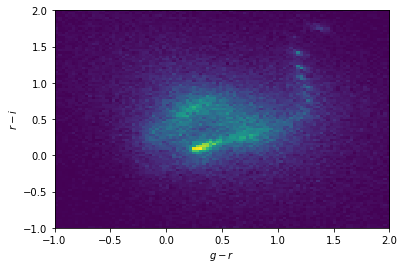

In [36]:
plt.hist2d(d['mag_g_cModel']-d['mag_r_cModel'],
           d['mag_r_cModel']-d['mag_i_cModel'], 
           bins=100,range=[(-1,2),(-1,2)]);
plt.xlabel('$g-r$')
plt.ylabel('$r-i$')

* Compare with the reference catalog or just show the plot with the comparison?

## Selecting a useful sample of galaxies: lensing cuts from HSC DR1

In this section, we will build step by step a sample of galaxies from the DC2 run1.1p coadd catalog, and compare it to an equivalent sample built from the HSC DR1 catalog.

### Sample selection

We will start from a set of basic sanity cuts that will select extended objects and reject problematic sources, including those for which shape measurement has failed.

One subtelty is that shape measurement is only run for the *reference band*, which is most of the time the i-band, but not always, we will further restrict the sample to objects for which we have i-band shapes using the `merge_measurement_i` flag.

==TODO==: Do we need to explain this further?

In [38]:
basic_cuts = [
    GCRQuery('extendedness > 0'),    # Extended objects
    GCRQuery('merge_measurement_i'), # Select objects for which the reference is the i-band
    
    GCRQuery('clean'), # The source has no flagged pixels (interpolated, saturated, edge, clipped...) 
                       # and was not skipped by the deblender
    ~GCRQuery('xy_flag'),                                       # Flag for bad centroid measurement
    ~GCRQuery('ext_shapeHSM_HsmShapeRegauss_flag'),             # Error code returned by shape measurement code
    ~GCRQuery((np.isnan, 'ext_shapeHSM_HsmShapeRegauss_sigma')) # Shape measurement uncertainty should not be NaN
]

In addition to these basic cuts, we will want to apply a set of cuts based on object properties, to ensure we are selecting well resolved and well measured galaxies. One of these properties is the measured total distortion, which is not directly defined in the schema, but can be derived from the measured $e1$, $e2$ distortion components. 

The GCR provides a convenience function, `add_quantity_modifier`, to add this quantity to the schema on the fly, so that we can use it afterwards to build our cuts:

In [57]:
# Adds a new derived column
catalog.add_quantity_modifier('shape_hsm_regauss_etot', 
                              (np.hypot, 'ext_shapeHSM_HsmShapeRegauss_e1', 'ext_shapeHSM_HsmShapeRegauss_e2'), 
                              overwrite=True)

# Define lensing cuts on galaxy properties 
properties_cuts = [
    GCRQuery('snr_i_cModel > 10'),                              # SNR > 10
    GCRQuery('mag_i_cModel < 24.5'),                            # cModel imag brighter than 24.5
    GCRQuery('ext_shapeHSM_HsmShapeRegauss_resolution >= 0.3'), # Sufficiently resolved galaxies compared to PSF
    GCRQuery('shape_hsm_regauss_etot < 2'),                     # Total distortion in reasonable range
    GCRQuery('ext_shapeHSM_HsmShapeRegauss_sigma <= 0.4')       # Shape measurement errors reasonable
]

# We can now extract our lensing sample 
quantities = ['mag_i_cModel', 'snr_i_cModel', 'shape_hsm_regauss_etot', 'ext_shapeHSM_HsmShapeRegauss_resolution']
data = catalog.get_quantities(quantities, 
                           filters=basic_cuts + properties_cuts, 
                           native_filters=[(lambda x: x==4849, 'tract')])

/global/common/software/lsst/common/miniconda/current/lib/python3.6/site-packages/GCRCatalogs/dc2_coadd.py:164: RuntimeWarning: divide by zero encountered in log10
  lambda x: -2.5 * np.log10(x) + 27.0,
/global/common/software/lsst/common/miniconda/current/lib/python3.6/site-packages/GCRCatalogs/dc2_coadd.py:164: RuntimeWarning: invalid value encountered in log10
  lambda x: -2.5 * np.log10(x) + 27.0,


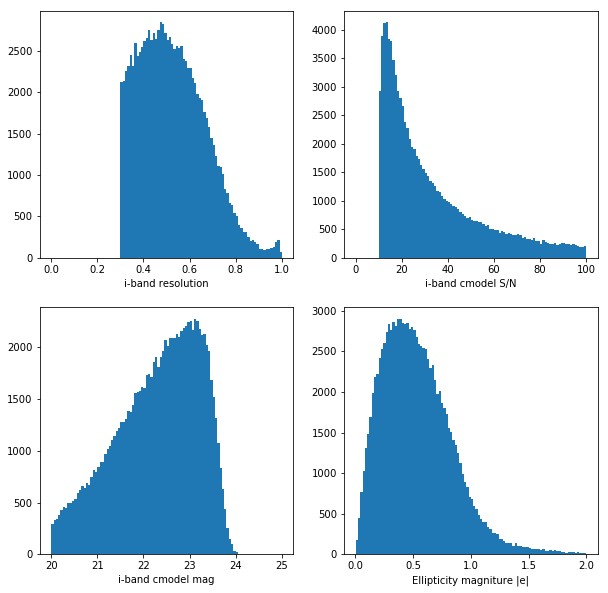

In [61]:
figure(figsize=(10,10))
subplot(221)
hist(data['ext_shapeHSM_HsmShapeRegauss_resolution'], 100, range=[0,1]);
xlabel('i-band resolution')
xlim()
subplot(222)
hist(data['snr_i_cModel'], 100, range=[0,100])
xlabel('i-band cmodel S/N')
subplot(223)
hist(data['mag_i_cModel'], 100, range=[20,25]);
xlabel('i-band cmodel mag')
subplot(224)
hist(data['shape_hsm_regauss_etot'],100);
xlabel('Ellipticity magniture |e|');

You can compare this plot to Fig 12. in [Mandelbaum et al. 2017](https://arxiv.org/pdf/1705.06745.pdf). A quick visual comparison will highlight two things:

  - We are missing a lot of galaxies between 23 and 24.5 mag
  - We have a bump near resolution of 1

We are going to investigate to understand these differences below

### Plotting a depth map

In [110]:
# Stolen from Javier's DC2 matching and depth notebook
import healpy as hp

def binned_statistic(x, values, func, nbins, range):
    '''The usage is approximately the same as the scipy one
    from https://stackoverflow.com/questions/26783719/effic
    iently-get-indices-of-histogram-bins-in-python'''
    from scipy.sparse import csr_matrix
    r0, r1 = range
    mask = (x > r0) &  (x < r1)
    x = x[mask]
    values = values[mask]
    N = len(values)
    digitized = (float(nbins) / (r1-r0) * (x-r0)).astype(int)
    S = csr_matrix((values, [digitized, np.arange(N)]), shape=(nbins, N))
    return np.array([func(group) for group in np.split(S.data, S.indptr[1:-1])])

def  depth_map_snr (ra,dec,mags,snr,nside=2048):
    good = np.logical_or(np.logical_not(np.isnan(ra)),np.logical_not(np.isnan(dec)))
    pix_nums = hp.ang2pix(nside,np.pi/2.-dec[good]*np.pi/180,ra[good]*np.pi/180)
    map_out = np.zeros(12*nside**2)
    #Binned statistic 2d is awfully slow (because it doesn't use the fact that all bins are equal width
    #median_snr, xed, _, _ = binned_statistic_2d(mags,pix_nums,snr,statistic='median',bins=(50,12*nside**2),range=[(20,30),(0,12*nside**2)])
    #bin_centers = 0.5*xed[1:]+0.5*xed[:-1]
    #depth = bin_centers[np.argmin(np.fabs(median_snr-5),axis=0)]
    map_out = np.zeros(12*nside**2)
    bin_centers = np.linspace(22+6/30.,28-6/30.,30.)
    for px in np.unique(pix_nums):
        mask = px==pix_nums
        if np.count_nonzero(mask)>0:
            median_snr = binned_statistic(mags[mask],snr[mask],np.nanmedian,nbins=30,range=(22,28))
            mask2 = np.isnan(median_snr)==False
            if np.count_nonzero(mask2)>0:
                depth = bin_centers[mask2][np.argmin(np.fabs(median_snr[mask2] - 5.))]
                map_out[px]=depth
            else:
                map_out[px]=0
        else:
            map_out[px]=0.
    return map_out

In [121]:
quantities = ['ra', 'dec', 'mag_i_cModel', 'snr_i_cModel', 'ext_shapeHSM_HsmShapeRegauss_resolution']

# Data from DC2 run1.1p
data = catalog.get_quantities(quantities, filters=basic_cuts, native_filters=[(lambda x: x==4849, 'tract')])

# Compare to HSC 
cat_hsc = GCRCatalogs.load_catalog('hsc-pdr1-xmm')
data_hsc = cat_hsc.get_quantities(quantities, filters=basic_cuts)

/global/common/software/lsst/common/miniconda/current/lib/python3.6/site-packages/GCRCatalogs/dc2_coadd.py:164: RuntimeWarning: divide by zero encountered in log10
  lambda x: -2.5 * np.log10(x) + 27.0,
/global/common/software/lsst/common/miniconda/current/lib/python3.6/site-packages/GCRCatalogs/dc2_coadd.py:164: RuntimeWarning: invalid value encountered in log10
  lambda x: -2.5 * np.log10(x) + 27.0,


In [122]:
# Compute i-band depth map
m5map = depth_map_snr(data['ra'],data['dec'],data['mag_i_cModel'], data['snr_i_cModel'] )
m5map_hsc = depth_map_snr(data_hsc['ra'],data_hsc['dec'],data_hsc['mag_i_cModel'], data_hsc['snr_i_cModel'] )

print("Run1.1p median i-band 5 sigma depth ", median(m5map[m5map > 0]))
print("Run1.1p median i-band 5 sigma depth ", median(m5map_hsc[m5map_hsc > 0]))

/global/common/software/lsst/common/miniconda/current/lib/python3.6/site-packages/ipykernel/__main__.py:27: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
/global/common/software/lsst/common/miniconda/current/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:990: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/global/common/software/lsst/common/miniconda/current/lib/python3.6/site-packages/ipykernel/__main__.py:10: RuntimeWarning: invalid value encountered in greater
/global/common/software/lsst/common/miniconda/current/lib/python3.6/site-packages/ipykernel/__main__.py:10: RuntimeWarning: invalid value encountered in less


Run1.1p median i-band 5 sigma depth  24.5172413793
Run1.1p median i-band 5 sigma depth  26.0620689655


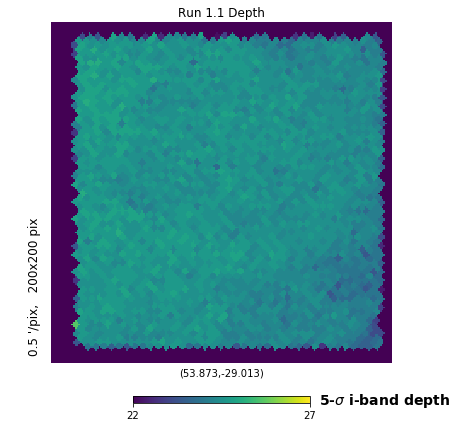

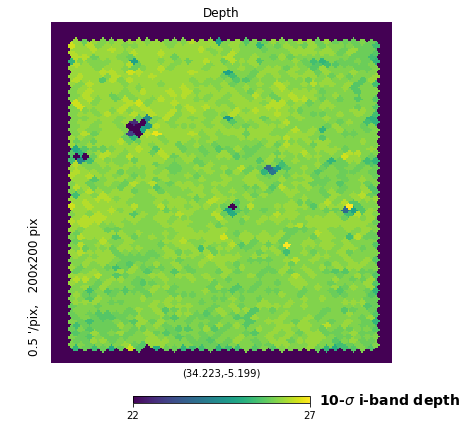

In [126]:
# Let's visually compare the 2 depth maps
hp.gnomview(m5map,rot=(data['ra'].mean(), data['dec'].mean()), title='Run 1.1 Depth', reso=0.5,unit='5-$\sigma$ i-band depth',min=22, max=27.)
hp.gnomview(m5map_hsc,rot=(data_hsc['ra'].mean(), data_hsc['dec'].mean()), title='Depth', reso=0.5,unit='10-$\sigma$ i-band depth',min=22, max=27.)

### Impact of blendedness

TBD
 - Create a list of offensive objects at high resolution
 - Link to Michael's postage stamp tutorial to get a look at those
 - Hopefully, highlight the fact that they are close to / in blends
 - Impose cut on blendedness, see the bump go away, success

## Challenge: Galaxy counts-in-cells

Blending affects the accuracy of centroid and flux measurements. It can potentially generate a systematic effect in different measurements (for example 2-point statistics). 

The stack, returns a very useful value to check (partially) for the presence of these kind of systematics, which is the `blendedness` parameter (more details on Section 4.9.11 of [Bosch et al. 2017](https://arxiv.org/pdf/1705.06766.pdf)

* Q: Why partially?


A very simple tool to measure the different statistical moments of galaxies is Counts-in-cells (CiC) [Peebles et al. 1980](https://press.princeton.edu/titles/724.html). Here, we are going to use a simplified version of CiC to check the possible systematic effects due to differences in the `blendedness` measurements.

In [ ]:
from cic import cic_analysis

In [ ]:
import healpy as hp

In [ ]:
# Let's use almost the same cuts as in the WL sample
cic_cuts_nb = [
    ~GCRQuery((np.isnan, 'mag_i_cModel')), # (from this and below) remove nan entries
    ~GCRQuery((np.isnan, 'ext_shapeHSM_HsmShapeRegauss_resolution')),
    ~GCRQuery((np.isnan, 'ext_shapeHSM_HsmShapeRegauss_e1')),
    ~GCRQuery((np.isnan, 'ext_shapeHSM_HsmShapeRegauss_e2')),
    GCRQuery('good'), 
    GCRQuery('snr_i_cModel >= 10'), # (from this and below) cut on object properties
    GCRQuery('HSM_res >= 0.3'),
    GCRQuery('HSM_ell < 2.0'),
    GCRQuery('ext_shapeHSM_HsmShapeRegauss_sigma <= 0.4'),
    GCRQuery('blendedness < 10**(-0.375)'),
]

cic_cuts_b = [
    ~GCRQuery((np.isnan, 'mag_i_cModel')), # (from this and below) remove nan entries
    ~GCRQuery((np.isnan, 'ext_shapeHSM_HsmShapeRegauss_resolution')),
    ~GCRQuery((np.isnan, 'ext_shapeHSM_HsmShapeRegauss_e1')),
    ~GCRQuery((np.isnan, 'ext_shapeHSM_HsmShapeRegauss_e2')),
    GCRQuery('good'), 
    GCRQuery('snr_i_cModel >= 10'), # (from this and below) cut on object properties
    GCRQuery('HSM_res >= 0.3'),
    GCRQuery('HSM_ell < 2.0'),
    GCRQuery('ext_shapeHSM_HsmShapeRegauss_sigma <= 0.4'),
    GCRQuery('blendedness > 10**(-0.375)'),
]

quantities = ['ra','dec']
d_nb = catalog.get_quantities(quantities, 
                           filters=cic_cuts_nb, 
                           native_filters=[(lambda x: x==tract_number, 'tract')])
d_b = catalog.get_quantities(quantities, 
                           filters=cic_cuts_b, 
                           native_filters=[(lambda x: x==tract_number, 'tract')])

sigma_b, sigma_err_b, skw_b, skw_err_b, kurtosis_b, kurtosis_err_b, pixel_scale = cic_analysis(d_b)
sigma_nb, sigma_err_nb, skw_nb, skw_err_nb, kurtosis_nb, kurtosis_err_nb, _  = cic_analysis(d_nb)
#TODO: Include CiC with shapes?

In [ ]:
plt.errorbar(pixel_scale, sigma_b, sigma_err_b, fmt='o', linestyle='none', label='High blendedness')
plt.errorbar(pixel_scale, sigma_nb, sigma_err_nb, fmt='x', linestyle='none', label='Low blendedness')
plt.legend()
plt.xlabel('Pixel scale [deg]')
plt.ylabel(r'$\sigma$')

## Challenge: Check if PSF residuals are within requirements

- First explain how the DM stack models stars and PSF
- How to select a sample of good looking stars
- compute rho statistics in stile

In [ ]:
catalog = GCRCatalogs.load_catalog('dc2_coadd_run1.1p')

In [ ]:
#TODO: A few words about PSF modeling

In [ ]:
# Adds modifiers to compute stars size and ellipticity
g1_modif = lambda ixx,iyy,ixy: (ixx-iyy)/(ixx+iyy)
g2_modif = lambda ixx,iyy,ixy:  2.*ixy/(ixx+iyy)
sigma_modif = lambda ixx,iyy,ixy: (ixx*iyy - ixy**2)**0.25

catalog.add_modifier_on_derived_quantities('g1', g1_modif, 'Ixx', 'Iyy', 'Ixy')
catalog.add_modifier_on_derived_quantities('g2', g2_modif, 'Ixx', 'Iyy', 'Ixy')
catalog.add_modifier_on_derived_quantities('sigma', sigma_modif, 'Ixx', 'Iyy', 'Ixy')

catalog.add_modifier_on_derived_quantities('psf_g1', g1_modif, 'IxxPSF', 'IyyPSF', 'IxyPSF')
catalog.add_modifier_on_derived_quantities('psf_g2', g2_modif, 'IxxPSF', 'IyyPSF', 'IxyPSF')
catalog.add_modifier_on_derived_quantities('psf_sigma', sigma_modif, 'IxxPSF', 'IyyPSF', 'IxyPSF')

In [ ]:
# Extracting data selecting only point sources
data = catalog.get_quantities(['ra', 'dec', 'mag_i', 'i_SNR', 'psf_fwhm_i',
                               'g1', 'g2', 'sigma',
                               'psf_g1', 'psf_g2', 'psf_sigma'], 
                               # native_filters=[(lambda x: x==4850, 'tract')],
                                filters=[GCRQuery('good'), 
                                         GCRQuery('clean'), 
                                        ~GCRQuery('I_flag'),
                                        ~GCRQuery('base_SdssShape_flag_badCentroid'),
                                         GCRQuery('extendedness == 0'),
                                        ~GCRQuery((np.isnan, 'mag_i_cModel')), # (from this and below) remove nan entries
                                        ~GCRQuery((np.isnan, 'ext_shapeHSM_HsmShapeRegauss_resolution')),
                                        ~GCRQuery((np.isnan, 'ext_shapeHSM_HsmShapeRegauss_e1')),
                                        ~GCRQuery((np.isnan, 'ext_shapeHSM_HsmShapeRegauss_e2')),
                                         GCRQuery('blendedness < 10**(-0.375)'),
                                         GCRQuery('mag_i < 21')])

In [ ]:
figure(figsize=(10,5))

subplot(121)
hist2d(data['mag_i'], (data['sigma'] - data['psf_sigma'])/data['psf_sigma'], 100, range=[[15,23],[-0.02,0.02]]);
xlabel('i mag')
ylabel('$f \delta_\sigma$')
subplot(122)
hist2d(data['psf_fwhm_i'], (data['sigma'] - data['psf_sigma'])/data['psf_sigma'], 100, range=[[0.4,1.0],[-0.02,0.02]]);
xlabel('seeing FWHM (arcsec)')

In [ ]:
figure(figsize=(15,10))

subplot(221)
hist2d(data['mag_i'], (data['g1'] - data['psf_g1']), 100, range=[[15,23],[-0.02,0.02]]);
xlabel('i mag')
ylabel('$g_1 - g_1^{PSF}$')
subplot(222)
hist2d(data['psf_fwhm_i'], (data['g1'] - data['psf_g1']), 100, range=[[0.4,1.0],[-0.02,0.02]]);
xlabel('seeing FWHM (arcsec)')
ylabel('$g_1 - g_1^{PSF}$')

subplot(223)
hist((data['g1'] - data['psf_g1']), 100, range=[-0.04,0.04]);
xlabel('$g_1 - g_1^{PSF}$')
axvline(0)
subplot(224)
hist((data['g2'] - data['psf_g2']), 100, range=[-0.04,0.04]);
xlabel('$g_2 - g_2^{PSF}$')
axvline(0)

In [ ]:
import pandas
import stile

d = pandas.DataFrame(data)
d['w'] =1
d = d.to_records(index=False)

In [ ]:
stile_args = {'ra_units': 'degrees', 'dec_units': 'degrees',
              'min_sep': 0.05, 'max_sep': 1, 'sep_units': 'degrees', 'nbins': 20}

In [ ]:
rho1 = stile.CorrelationFunctionSysTest('Rho1')
rho2 = stile.CorrelationFunctionSysTest('Rho2')

r1 = rho1(d, config=stile_args)
r2 = rho2(d, config=stile_args)

In [ ]:
f = rho1.plot(r1);

In [ ]:
f = rho2.plot(r2);